In [1]:
# For if you want to just be working in your cloned git directory, and not installed to a python environment
import os
import sys
module_path = os.path.abspath(os.path.join('pyccd-1.x'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [2]:
%matplotlib inline
import ccd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import datacube
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb

In [6]:
import planetary_computer
import pystac_client
import odc.stac
import odc.geo.xr
from odc.geo.geom import BoundingBox

In [31]:
# Define the area of interest
x = (119.859, 119.862)
y = (-23.310, -23.307)

# Set the range of dates for the analysis
time = ("2005-01", "2008-01")

In [32]:
dc = datacube.Datacube(app="Landsat_Surface_Reflectance")
ds = load_ard(dc=dc,
              products=["ga_ls5t_ard_3", "ga_ls7e_ard_3"],
              # products=["ga_ls5t_ard_3", "ga_ls7e_ard_3","ga_ls8c_ard_3"],
              measurements=['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'fmask'],
              output_crs='EPSG:6933',
              y=y,
              x=x,
              time=time,
              resolution=(-30, 30),
              group_by="solar_day",
             )
ds

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
Applying fmask pixel quality/cloud mask
Loading 123 time steps


<xarray.Dataset>
Dimensions:      (time: 123, y: 12, x: 11)
Coordinates:
  * time         (time) datetime64[ns] 2005-01-02T01:46:14.778895 ... 2008-01...
  * y            (y) float64 -2.894e+06 -2.894e+06 ... -2.894e+06 -2.894e+06
  * x            (x) float64 1.156e+07 1.156e+07 ... 1.157e+07 1.157e+07
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swir_2       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    fmask        (time, y, x) uint8 2 2 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [33]:
# Open a client pointing to the Microsoft Planetary Computer data catalogue
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [34]:
# Convert data-cube style queries into something readable by `pystac_client`
bbox = BoundingBox.from_xy(x, y)
time_range = "/".join(time)

# Search for STAC items, filtering to Landsat 8 data only
search = catalog.search(
    collections="landsat-c2-l2",
    bbox=bbox,
    datetime=time_range,
    query={
        "platform": {"in": ["landsat-5","landsat-7"]},
        # "platform": {"in": ["landsat-5","landsat-7","landsat-8"]},
    },
)

# Check how many items were returned
items = search.item_collection()
print(f"Found {len(items)} STAC items")

Found 127 STAC items


In [37]:
# Load Landsat surface temperature data with ODC STAC
ds_usgs = odc.stac.load(
    items,
    bbox=bbox,
    bands=["lwir"],
    # bands=["lwir11"],
    crs="EPSG:6933",
    resolution=30,
    groupby="solar_day",
)

# Inspect outputs
ds_usgs

<xarray.Dataset>
Dimensions:      (y: 12, x: 11, time: 127)
Coordinates:
  * y            (y) float64 -2.894e+06 -2.894e+06 ... -2.894e+06 -2.894e+06
  * x            (x) float64 1.156e+07 1.156e+07 ... 1.157e+07 1.157e+07
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2005-01-02T01:46:14.823172 ... 2008-01...
Data variables:
    lwir         (time, y, x) uint16 33749 34172 34866 35488 36159 ... 0 0 0 0 0

In [38]:
# First set 0 values to nodata
ds_usgs = ds_usgs.where(ds_usgs != 0)

# Apply USGS Collection 2 surface temperature scaling factors to obtain
# temperature in degrees Kelvin
ds_usgs = (ds_usgs * 0.00341802 + 149.0)
ds_usgs

<xarray.Dataset>
Dimensions:      (y: 12, x: 11, time: 127)
Coordinates:
  * y            (y) float64 -2.894e+06 -2.894e+06 ... -2.894e+06 -2.894e+06
  * x            (x) float64 1.156e+07 1.156e+07 ... 1.157e+07 1.157e+07
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2005-01-02T01:46:14.823172 ... 2008-01...
Data variables:
    lwir         (time, y, x) float64 264.4 265.8 268.2 270.3 ... nan nan nan

In [39]:
# Timesteps in both datasets differ by milliseconds, which prevents
# xarray from automatically combining them. To work around this, first
# use `.interp_like` to ensure times in both datasers are identical
ds["degrees_kelvin"] = ds_usgs.lwir.interp_like(ds, method="nearest")
# ds["degrees_kelvin"] = ds_usgs.lwir11.interp_like(ds, method="nearest")
ds

<xarray.Dataset>
Dimensions:         (time: 123, y: 12, x: 11)
Coordinates:
  * time            (time) datetime64[ns] 2005-01-02T01:46:14.778895 ... 2008...
  * y               (y) float64 -2.894e+06 -2.894e+06 ... -2.894e+06 -2.894e+06
  * x               (x) float64 1.156e+07 1.156e+07 ... 1.157e+07 1.157e+07
    spatial_ref     int32 6933
Data variables:
    blue            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    red             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nir             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swir_1          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swir_2          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    fmask           (time, y, x) uint8 2 2 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0 0
    degrees_kelvin  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [40]:
ds_mean = ds.mean(dim=["x", "y"])
ds_mean

<xarray.Dataset>
Dimensions:         (time: 123)
Coordinates:
  * time            (time) datetime64[ns] 2005-01-02T01:46:14.778895 ... 2008...
    spatial_ref     int32 6933
Data variables:
    blue            (time) float32 nan 336.2 374.9 330.8 ... nan 437.2 384.3
    green           (time) float32 nan 644.2 688.6 661.5 ... nan 751.0 682.4
    red             (time) float32 nan 901.5 1.005e+03 ... 1.154e+03 1.172e+03
    nir             (time) float32 nan 1.954e+03 ... 1.734e+03 1.764e+03
    swir_1          (time) float32 nan 2.118e+03 ... 2.701e+03 2.629e+03
    swir_2          (time) float32 nan 1.56e+03 ... 2.232e+03 2.163e+03
    fmask           (time) float64 2.0 1.0 0.3712 1.0 ... 0.8788 1.0 0.7803
    degrees_kelvin  (time) float64 nan 319.4 319.2 323.5 ... 248.5 330.4 327.0

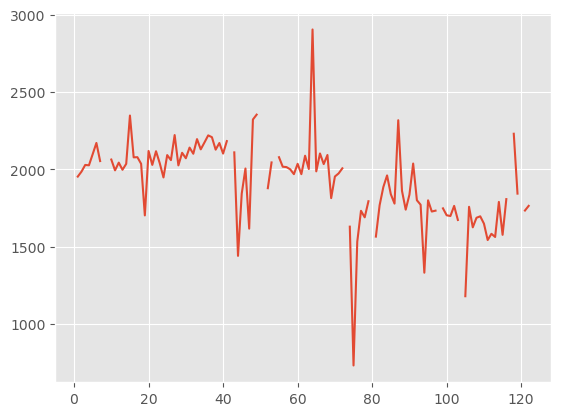

In [61]:
plt.plot(ds_mean['nir'])

In [41]:
params = {'QA_BITPACKED': False,
    'QA_FILL': 0,
    'QA_CLEAR': 1,
    'QA_WATER': 5,
    'QA_SHADOW': 3,
    'QA_SNOW': 4,
    'QA_CLOUD': 2}

In [54]:
dates = (ds_mean.time.values - np.datetime64(0,'D'))/np.timedelta64(86400000000000, 'ns')
quality = np.ones(len(ds_mean.time.values)).astype(np.int16)
blues, greens, reds, nirs, swir1s, swir2s, thermals=ds_mean.blue.values, ds_mean.green.values, ds_mean.red.values,ds_mean.nir.values, ds_mean.swir_1.values, ds_mean.swir_2.values,ds_mean.degrees_kelvin.values
results = ccd.detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, quality, params=params)

Start Date: 0036-01-02 00:00:00
End Date: 0039-01-26 00:00:00



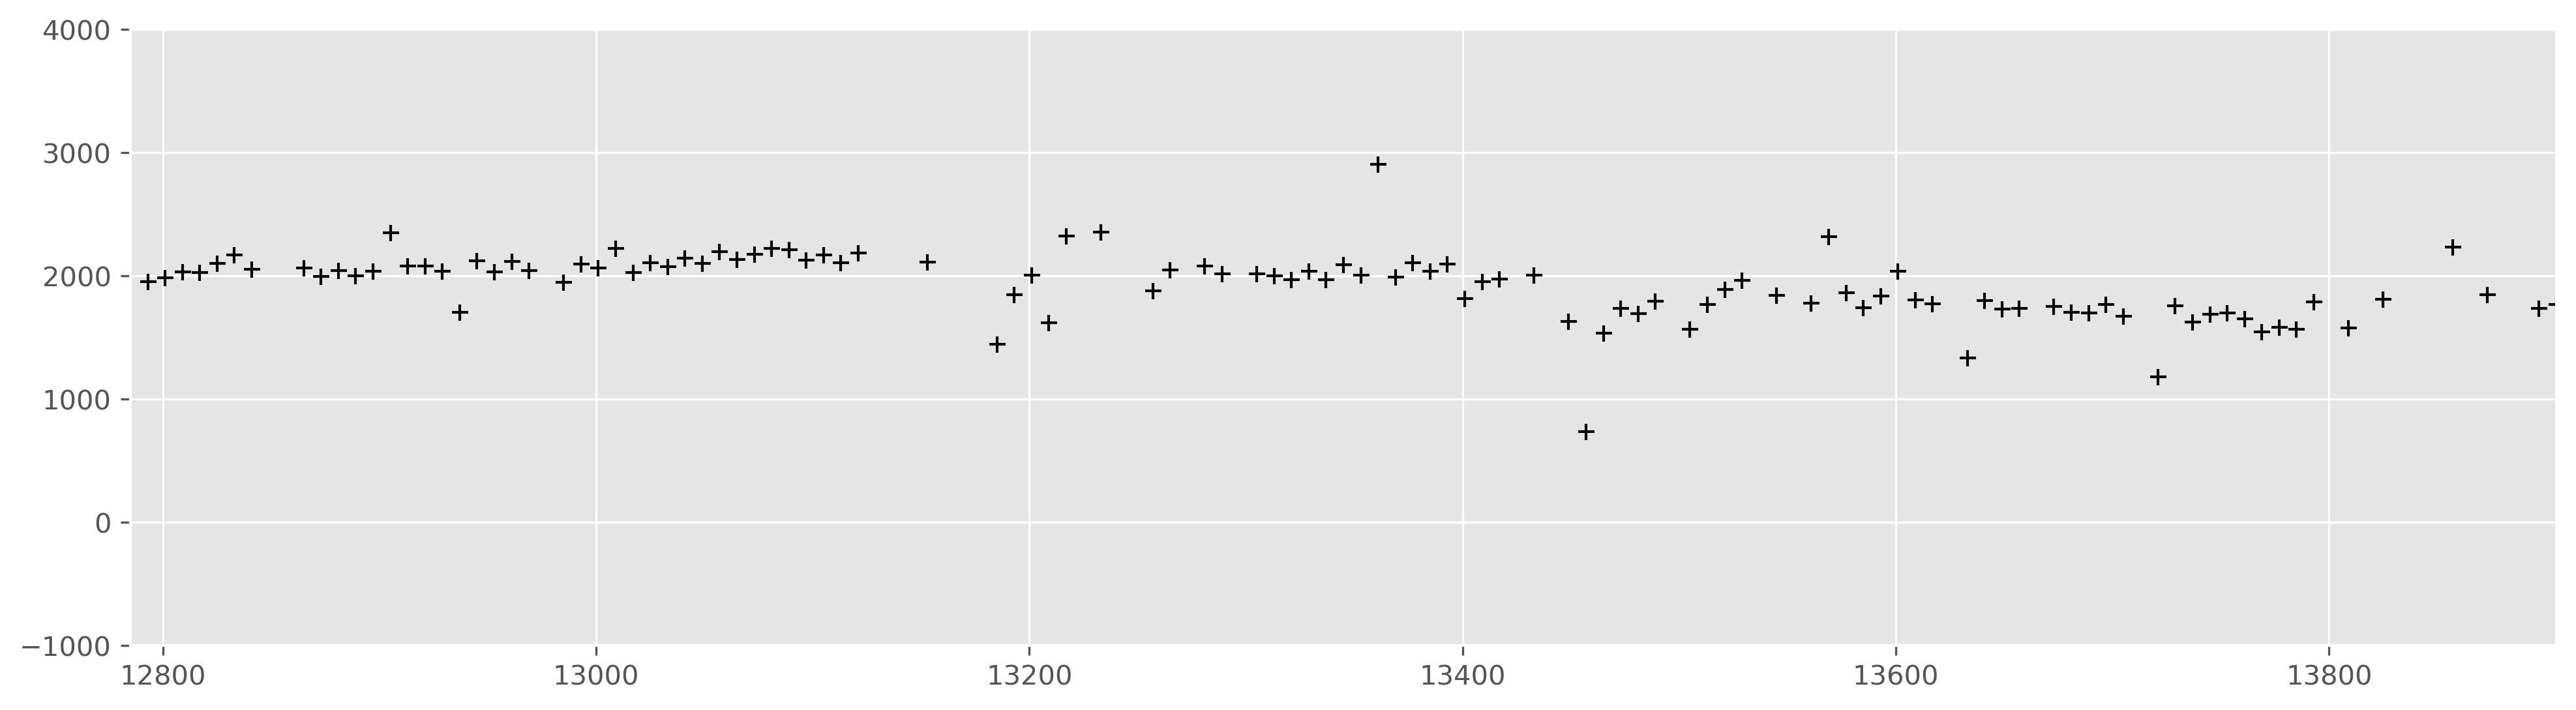

In [63]:
dates=dates.astype(int)
mask = np.array(results['processing_mask'], dtype=bool)
print('Start Date: {0}\nEnd Date: {1}\n'.format(datetime.fromordinal(dates[0]),
                                                datetime.fromordinal(dates[-1])))

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(datetime.fromordinal(result['start_day'])))
    print('End Date: {}'.format(datetime.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(datetime.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Norm: {}\n'.format(np.linalg.norm([result['green']['magnitude'],
                                            result['red']['magnitude'],
                                            result['nir']['magnitude'],
                                            result['swir1']['magnitude'],
                                            result['swir2']['magnitude']])))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    prediction_dates.append(days)
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    
    intercept = result['nir']['intercept']
    coef = result['nir']['coefficients']
    
    predicted_values.append(intercept + coef[0] * days +
                            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
    
plt.style.use('ggplot')

fg = plt.figure(figsize=(16,9), dpi=300)
a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)), ylim=(-1000, 4000))

# Predicted curves
for _preddate, _predvalue in zip(prediction_dates, predicted_values):
    a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

a1.plot(dates[mask], nirs[mask], 'g+') # Observed values
a1.plot(dates[~mask], nirs[~mask], 'k+') # Observed values masked out
for b in break_dates: a1.axvline(b)
for s in start_dates: a1.axvline(s, color='r')